https://arxiv.org/abs/1704.00028 

Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract

In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 6.3MB/s 


In [ ]:
from pyunpack import Archive
Archive('./drive/MyDrive/weights/swords.7z').extractall("./")
#Archive('./drive/My Drive/ds_swords.7z').extractall("./ds_swords")

Hyperparameters

In [ ]:
batch_size = 70
desc_lr = 1e-4
gen_lr = 1e-4
epochs = 300
critic_count_of_steps = 5
lambda_term = 10
b1= 0.5
b2 = 0.999
'''
flat_size = 35775
dropout_prob = 0.3
desc_l1 = 1024
desc_l2 = 512
desc_l3 = 256
noise_size = 100
gen_l1 = 256
gen_l2 = 512
gen_l3 = 1024
'''
image_scale = 4

desc_inp_l = 3
desc_l = 128
desc_flat_l = 4 * (image_scale ** 2)


gen_inp_l = 100
gen_l = 128
gen_out_l = 3

avg_t = 14



noise_x_size = 1
noise_y_size = 4

pic_x_size = 32 * image_scale
pic_y_size = 128 * image_scale

Augumentation generation

In [ ]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-op_h94ip
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-op_h94ip
  Created wheel for imgaug: filename=imgaug-0.4.0-cp37-none-any.whl size=971106 sha256=8f74cee8746ab8c6c5b0dee40ebeeaf730ec63936c27cb847f5f5fc5ed0ee9ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-iryhf2w0/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from PIL import Image
import numpy as np
import os
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

'''
w = []
h = []
for filename in os.listdir('./swords'):
    img = Image.open('./swords/'+filename)
    w.append(img.size[1])
    h.append(img.size[0])

print(np.median(h), np.median(w))
'''
class Augmenter:

    def __init__(self, inDirPath, outDirPath):
        imagesNotResized = self._getImages(inDirPath)
        #self.h, self.w = self._getSizeMedians(imagesNotResized)
        self.h, self.w = pic_y_size, pic_x_size
        self.images = self._toSameFormat(imagesNotResized)
        self.outDirPath = outDirPath


    def _getImages(self, dirPath):
        res = []
        for filename in os.listdir(dirPath):
            img = Image.open(os.path.join(dirPath, filename))
            res.append(img)
        return res
    
    '''
    def _getSizeMedians(self, images):
        w = []
        h = []
        for img in images:
            h.append(img.size[1])
            w.append(img.size[0])
        print(np.median(h), np.median(w))
        return int(np.median(h)), int(np.median(w))
    '''

    def _toSameFormat(self, images):
        res = []
        desired_w = self.w
        desired_h = self.h
        for img in images:
            x, y = img.size
            pixels = img.getcolors(x * y)

            most_frequent_pixel = pixels[0]

            for count, colour in pixels:
                if count > most_frequent_pixel[0]:
                    most_frequent_pixel = (count, colour)

            if y / 2 < x:
              size = x * 2
            else:
              size = y

            new_img = Image.new('RGB', (int(size / 2), size), most_frequent_pixel[1])
            new_img.paste(img, (int((size / 2 - x) / 2), int((size - y) / 2)))
            new_img = new_img.resize((desired_w, desired_h))
            res.append(np.asarray(new_img))
            #res.append(np.asarray(img.resize((desired_w, desired_h))))
            #res.append(img.resize((self.h, self.w)))
        #res[-1].show()
        return res

    def augment(self):
        seq = iaa.Sequential([
                iaa.ChannelShuffle(0.1),
                iaa.Invert(0.5),
                iaa.AdditiveGaussianNoise(scale=(0, 0.01*255))
                #iaa.Dropout(0.01)
                ])
        res = []
        for i in range(10):
            res.extend(seq(images = self.images))
        return res

    def saveImages(self, np_images):
        i = 0
        for i in range(len(np_images)):
            img = Image.fromarray(np_images[i])
            img.save(os.path.join(self.outDirPath, str(i)+'.bmp'), 'BMP')
            

os.mkdir('./ds_swords')
aug = Augmenter('./swords','./ds_swords')
imgs = aug.augment()
aug.saveImages(imgs)

Data

In [ ]:
import torch
from torchvision import transforms
from torch.autograd import Variable

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

class Dataset(torch.utils.data.Dataset):

  def __init__(self, dirPath):
    super(Dataset, self).__init__()
    self.pics = self._load(dirPath)

  def _load(self, dirPath):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    res = []
    #for filename in os.listdir('./ds_swords'):
    for filename in os.listdir(dirPath):
      img = Image.open(os.path.join(dirPath, filename))
      transformed_img = transform(img)
      #dim_replaced_img = transformed_img.permute(1, 2, 0)
      res.append(transformed_img)
    #print(res[-1].shape)
    #plt.show(res[-1])
    #print(res[-1].shape)
    '''
    tensor_to_pil = transforms.ToPILImage()(res[-1].permute(2, 0, 1))
    tensor_to_pil.save('test.png')
    '''
    return res

  def __len__(self):
    return len(self.pics)

  def __getitem__(self, idx):
    return self.pics[idx]

data = Dataset('./ds_swords')
data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)
num_batches = len(data_loader)  

Model

In [ ]:
import torch.nn.functional as F
import collections

if __name__ == '__main__':
    if torch.cuda.is_available():
        print('CUDA is available,',torch.cuda.device_count())
        print(torch.cuda.get_device_name(0))
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PrintLayer(torch.nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.size())
        return x

class GaussianNoise(torch.nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            return x + torch.autograd.Variable(torch.x(x.size()).to(device) * self.stddev)
        return x

class D(torch.nn.Module):
    def __init__(self):
        super(D, self).__init__()

        self.noise = GaussianNoise(10)

        self.main = torch.nn.Sequential(
            
            torch.nn.Conv2d(desc_inp_l, desc_l, 4, 2, 1, bias=False),  #128, 32 -> 64, 16
            torch.nn.InstanceNorm2d(desc_l, affine=True),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l, desc_l * 2, 4, 2, 1, bias=False), #64, 16 -> 32, 8
            #torch.nn.BatchNorm2d(desc_l * 2),
            torch.nn.InstanceNorm2d(desc_l * 2, affine=True),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 2, desc_l * 4, 4, 2, 1, bias=False), #32, 8 -> 16, 4
            #torch.nn.BatchNorm2d(desc_l * 4),
            torch.nn.InstanceNorm2d(desc_l * 4, affine=True),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 4, desc_l * 8, 4, 2, 1, bias=False), #16, 4 -> 8, 2
            #torch.nn.BatchNorm2d(desc_l * 8),
            torch.nn.InstanceNorm2d(desc_l * 8, affine=True),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 8, 1, 4, 2, 1, bias=False), #8, 2 -> 4, 1
        )
        self.out = torch.nn.Sequential(torch.nn.Linear(desc_flat_l, 1))

    def forward(self, x):
        #x = self.noise(x)
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

    def forward_with_feature_extraction(self, x):
        #x = self.noise(x)
        x = self.main(x)
        features = x.view(x.size(0), -1)
        x = self.out(features)
        return x, features

class G(torch.nn.Module):
    def __init__(self):
        super(G, self).__init__()
        
        self.main = torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(gen_inp_l, gen_inp_l, 4, 2, 1, bias=False), #4, 1 -> 8, 2
            torch.nn.BatchNorm2d(gen_inp_l),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(gen_inp_l, gen_inp_l, 4, 2, 1, bias=False), #4, 1 -> 8, 2
            torch.nn.BatchNorm2d(gen_inp_l),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(gen_inp_l, gen_l * 8, 4, 2, 1, bias=False), #4, 1 -> 8, 2
            torch.nn.BatchNorm2d(gen_l * 8),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 8, 4, 2, 1, bias=False), #8, 2 -> 16, 4
            torch.nn.BatchNorm2d(gen_l * 8),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 4, 4, 2, 1, bias=False), #16, 4 -> 32, 8
            torch.nn.BatchNorm2d(gen_l * 4),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 4, gen_l * 2, 4, 2, 1, bias=False), #32, 8 -> 64, 16
            torch.nn.BatchNorm2d(gen_l * 2),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d( gen_l * 2, 3, 4, 2, 1, bias=False), #64, 16 -> 128, 32
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x


def getNoise(size):
  noise = Variable(torch.randn(size, gen_inp_l, noise_y_size, noise_x_size))
  '''
  if image_scale == 1:
    return noise
  else:
    return noise.repeat(1, 1, image_scale, image_scale)
  '''
  return noise

def weights_init(m):
    classname = m.__class__.__name__
    if classname == 'VirtualBatchNorm2d':
      pass
    elif classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

discriminator = D().to(device)
discriminator.apply(weights_init)
generator = G().to(device)
generator.apply(weights_init)

CUDA is available, 1
Tesla V100-SXM2-16GB


G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(100, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

Load and save models

In [ ]:
def loadWeightsFromDrive(i = 0):
    if i == 0:
        generator.load_state_dict(torch.load('./drive/My Drive/weights/gen.pt'))
        discriminator.load_state_dict(torch.load('./drive/My Drive/weights/disc.pt'))
    else:
        generator.load_state_dict(torch.load('./drive/My Drive/weights/gen_'+str(i)+'.pt'))
        discriminator.load_state_dict(torch.load('./drive/My Drive/weights/disc_'+str(i)+'.pt'))


def saveWeights(i):
    torch.save(generator.state_dict(), 'gen_'+str(i)+'.pt')
    torch.save(discriminator.state_dict(), 'disc_'+str(i)+'.pt')

def loadWeights(i = 0):
    if i == 0:
        generator.load_state_dict(torch.load('gen.pt'))
        discriminator.load_state_dict(torch.load('disc.pt'))
    else:
        generator.load_state_dict(torch.load('gen_'+str(i)+'.pt'))
        discriminator.load_state_dict(torch.load('disc_'+str(i)+'.pt'))

loadWeightsFromDrive(125)

Train

In [ ]:
import tqdm
import copy
from torch import autograd

from PIL import Image
import numpy as np
import os
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

def wasserstein_loss(y_true, y_pred):
 	return torch.mean(y_true * y_pred)
  
def alt_loss(D_real, D_fake):
  return  torch.mean(D_fake) - torch.mean(D_real)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = desc_lr, betas=(b1, b2))
g_optimizer = torch.optim.Adam(generator.parameters(), lr = gen_lr, betas=(b1, b2))
criterion_critic = wasserstein_loss
d_loss_history = []
g_loss_history = []
#ref_batch = next(iter(data_loader))
ref_batch = getNoise(batch_size).to(device)

def ones_target(size):
    data = Variable(torch.ones(size, 1))
    return data

def minus_ones_target(size):
    data = Variable(torch.ones(size, 1) * -1)
    return data

def clip_weights(D):
  for p in D.parameters():
      p.data.clamp_(-0.01, 0.01)

def calculate_gradient_penalty(D, real_images, fake_images, batch_size):
        #https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
        eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3)).to(device)

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                                create_graph=True, retain_graph=True)[0]

        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term
        return grad_penalty



def train_critic(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    #error_real = criterion_critic(prediction_real.cpu(), ones_target(N) )

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    #error_fake = criterion_critic(prediction_fake.cpu(), minus_ones_target(N))
    '''
    error_avg = weights_historical_avergaging_loss(discriminator, deq_d, avg_t, mean_d)
    if torch.isnan(error_avg).any() == False:
      error = error_avg + error_real + error_fake
    '''
    #error = error_real + error_fake
    error = alt_loss(prediction_real, prediction_fake) + calculate_gradient_penalty(discriminator, real_data, fake_data, N)
    error.backward()
    # 1.3 Update weights with gradients
    optimizer.step()

    #clip_weights(discriminator)
    
    # Return error and predictions for real and fake inputs
    return error.cpu()



def train_generator(optimizer, N):
    optimizer.zero_grad()    # Sample noise and generate fake data
    fake_data = generator(getNoise(N).to(device))
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = -1 * torch.mean(prediction.cpu())
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error


def train(num_epochs):
  for epoch in tqdm.trange(num_epochs):
      g_epoch_loss = []
      d_epoch_loss = []
      for real_batch in data_loader:
          N = real_batch.size(0)        # 1. Train Discriminator

          for step in range(critic_count_of_steps):
            real_data = Variable(real_batch).to(device)        # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            with torch.no_grad():
              fake_data = generator(getNoise(N).to(device))        # Train D
            d_loss = train_critic(d_optimizer, real_data, fake_data)
            d_epoch_loss.append(d_loss.detach().numpy())

          # 2. Train Generator        # Generate fake data
                  # Train G
          g_loss = train_generator(g_optimizer, N)
          g_epoch_loss.append(g_loss.detach().numpy())
      d_loss_history.append(np.mean(d_epoch_loss))
      g_loss_history.append(np.mean(g_epoch_loss))
      if (epoch % 5 == 0 and (epoch != 0)) or epoch == num_epochs - 1:
        saveWeights(epoch)





train(epochs)

Test

In [ ]:
import matplotlib.pyplot as plt

def save_res_img(pic, name):
  
  print(pic.size())
  #1pic = pic.view(512, 128, 3)
  
  #pic = next(iter(data_loader))[0]
  #print(torch.min(pic), torch.max(pic))
  
  tensor_to_pil = transforms.ToPILImage()(pic)
  tensor_to_pil.save(name)
  
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.imshow(pic.permute(1,2,0))

def getPics(count):
  noise = getNoise(count).to(device)
  pics = generator(noise).detach().cpu()
  for i in range(len(pics)):
    save_res_img(pics[i], str(i)+'.png')

'''
#1050
noise_x_size = 1
noise_y_size = 4
'''

'''
plt.subplot(2, 1, 1)
plt.plot(range(len(d_loss_history)), d_loss_history)

plt.subplot(2, 1, 2)
plt.plot(range(len(g_loss_history)), g_loss_history)

plt.show()
'''

#loadWeights(120)
getPics(10)

Examples of generated swords

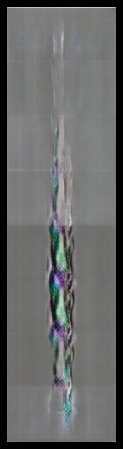

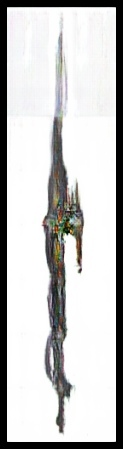

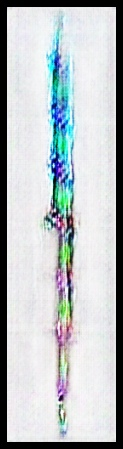

Examples of swords generated using the same dataset, but in lower resolution.

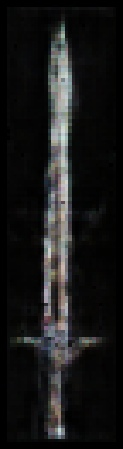

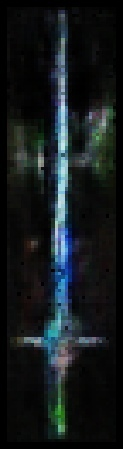

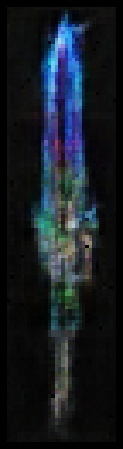

Archive generated dataset

In [ ]:
from zipfile import ZipFile
import os
from os.path import basename
# create a ZipFile object
with ZipFile('ds_swords.7z', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('./ds_swords'):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))